1. Import URIs
2. Import HTML

In [3]:
#!/usr/local/bin/bash

input="../bafe/bafe_articles.uris"

while IFS= read -r line
do
    outFile=$(echo "$line" | cut -d /  -f 5- | tr / _)
    curl $line -o $outFile.html
    pandoc -f html -t markdown $outFile.html -o $outFile.md
done < "$input"
# curl $1 |


SyntaxError: invalid syntax (<ipython-input-3-72f5527500cd>, line 5)

In [15]:

#  simple_json.py file containing the function simple_json_from_html_string().
#     Usage:

mypath="data/articles/bafe"


from os import *
from os.path import isfile, join
onlyhtmlfiles = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f[:5] == ".html")]


from readabilipy import simple_json_from_html_string

for file in onlyhtmlfiles:
    with os.open(file) as html_file:
        html_strings = readlines(html_file)
        article = simple_json_from_html_string(html_strings, content_digests=False, node_indexes=True, use_readability=True)
        with open('a', file+".json") as json_file:
            write(json_file, article)

        #The function returns a dictionary with the following fields:
         #   title: The article title
         #   byline: Author information
         #   content: A simplified HTML representation of the article, with all article text contained in paragraph elements.
         #   plain_content: A "plain" version of the simplified Readability.js article HTML present in the content field. This attempts to retain only the plain text content of the article, while preserving the HTML structure.
          #  plain_text: A list containing plain text representations of each paragraph (<p>) or list (<ol> or <ul>) present in the simplified Readability.js article HTML in the content field. Each paragraph or list is represented as a single string. List strings look like "* item 1, * item 2, * item 3," for both ordered and unordered lists (note the trailing ,).

ModuleNotFoundError: No module named 'readabilipy'

In [14]:
bashCommand = "git clone https://github.com/alan-turing-institute/ReadabiliPy.git"
import subprocess
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
process.communicate()

(b'', None)

In [ ]:
* add multilabel classification with  sklearn.multiclass.OneVsRestClassifier to learn proximity beween questions
* FIX BIG BUG IN models.py for question-object couples that don't already have a score.
* adjust weights

In [180]:
#nltk
#pip install any packages you don't have
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd
import re, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import calinski_harabaz_score

from collections import Counter

<h1>Load in Dataset

In [63]:
df = pd.read_csv('../Data/df_with_gensim_summaries.csv')

In [64]:
df.drop(['Unnamed: 0', 'Unnamed: 0.1.1'], axis = 1, inplace = True)

In [1]:
#df.head()

<h3>Tokenize

In [6]:
df.first_100 = df.first_100.str.lower()

In [7]:
df['tokenized_first_100'] = df.first_100.apply(lambda x: word_tokenize(x, language = 'en'))

<h3>Remove Stop Words

In [148]:
stops = list(set(stopwords.words('english'))) + list(punctuation) + ['s', "'", 't', 'and', '"', 'a', 'or', '/', 'in',
                                                                    'for', '&', '-', "''"]

In [488]:
#df.head()

In [147]:
#function to remove stop words
def remove_stops(text):
    text_no_stops = []
    for i in text:
        if i not in stops:
            if len(i) == 1:
                pass
            else:
                text_no_stops.append(i)
        else:
            pass
    return text_no_stops

In [12]:
df['first_100_no_stops'] = df['tokenized_first_100'].apply(lambda x: remove_stops(x))

In [155]:
#verify that it worked
#df.head()

<h3>Lemmatization

In [13]:
#initialize WordNetLemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

In [14]:
#function to lemmatize text
def lemmatize_text(text):
    lemmatized = []
    for word in text:
        lemmatized.append(lemmatizer.lemmatize(word))
    return lemmatized
        

In [15]:
df['lemmatize_first_100'] = df['first_100_no_stops'].apply(lemmatize_text)

In [16]:
df['lemmatize_first_100'] = df['lemmatize_first_100'].apply(lambda x: ' '.join(x))

In [126]:
#df.head()

In [18]:
#Checkpoint -- save to csv
#df.to_csv('df_with_lemmings.csv')

<h3>KMEANS CLUSTERING

In [155]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from langdetect import detect
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import words
from nltk.tokenize import RegexpTokenizer
import ast

<h3> Detect languages of articles

In [24]:
df['language'] = df['lemmatize_first_100'].apply(detect)

In [26]:
df.groupby('language').count()

title  content  category  gensim_summary  first_100  sent_tokenized  \
language                                                                        
en        97038    97038     84941           97038      97038           97038   
es            4        4         2               4          4               4   
fr           19       19        19              19         19              19   
it            2        2         2               2          2               2   
ko            1        1         1               1          1               1   

          tokenized_first_100  first_100_no_stops  lemmatize_first_100  
language                                                                
en                      97038               97038                97038  
es                          4                   4                    4  
fr                         19                  19                   19  
it                          2                   2                    2  
ko                          1                   1                    1

In [29]:
#drop rows that are not english
df = df.loc[df['language'] == 'en']

In [34]:
#df.to_csv('df_english_articles.csv')

<h3>Modeling

In [345]:
df = pd.read_csv('../Data/df_english_articles.csv')

In [157]:
stemmer = PorterStemmer()

In [152]:
#create function to stem each word in a list and concat the list
def stem_list(lst):
    stemmed_list = []
    for i in lst:
        stemmed_list.append(stemmer.stem(i))
    stem_string = ' '.join(stemmed_list)
    return stem_string

In [436]:
#convert list contained in string to a regular list so it can be stemmed
df['stemmed'] = df["first_100_no_stops"].apply(lambda x: ast.literal_eval(x))

In [442]:
#stem words in list
df['stemmed'] = df["stemmed"].apply(lambda x: stem_list(x))


In [450]:
#verify that it worked
#df.head()

In [447]:
#drop specific duplicate rows
df = df[~df['stemmed'].str.contains("archiveteam.org contain", case=False)]

In [448]:
df.shape

(95790, 12)

In [462]:
#CHECKPOINT --- SAVE TO CSV
#df.to_csv('df_with_stems_final.csv')

In [68]:
#CHECKPOINT --- RUN TO OPEN CSV IF STARTING WORK HERE
#df = pd.read_csv('df_with_stems_final.csv')
#df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1, inplace = True)

In [69]:
#df.head()

In [70]:
#create list of stemmed document strings
documents = df['stemmed'].to_list()

In [2]:
#preview list
#documents[:3]

In [72]:
#function to vectorize strings and perform tf-idf transformation
def vectorize_texts(list_of_strings):
    print('Performing vectorization and TF/IDF transformation on texts...')
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(list_of_strings)
    transformer = TfidfTransformer(smooth_idf=False)
    tfidf = transformer.fit_transform(X)
    return tfidf

In [73]:
def cluster_texts(num_clusters, tfidf):
    #perform kmeans clustering for range of clusters
    print('Beginning KMeans Clustering, number of clusters = ', num_clusters, '\n') 
    km = KMeans(n_clusters=num_clusters, max_iter = 100, verbose = 2, n_init = 1).fit(tfidf)
    
    
    return km

<h3>Run Clustering for range of K's

In [74]:
#vectorized the list of stemmed documents
documents_vectorized = vectorize_texts(documents)

Performing vectorization and TF/IDF transformation on texts...


In [75]:
#kmeans3 = cluster_texts(3, documents_vectorized)

In [79]:
#kmeans4= cluster_texts(4, documents_vectorized)

In [80]:
#kmeans5= cluster_texts(5, documents_vectorized)

In [81]:
#kmeans6= cluster_texts(6, documents_vectorized)

In [82]:
#kmeans7= cluster_texts(7, documents_vectorized)

In [83]:
#kmeans8= cluster_texts(8, documents_vectorized)

In [84]:
#kmeans9= cluster_texts(9, documents_vectorized)

In [85]:
#kmeans10= cluster_texts(10, documents_vectorized)

In [87]:
#kmeans11= cluster_texts(11, documents_vectorized)

In [128]:
#kmeans12= cluster_texts(12, documents_vectorized)

In [91]:
import pickle

In [92]:
#save kmeans12 model for further use
pickle.dump(kmeans12, open("../Models/kmeans12.pkl", "wb"))

In [ ]:
#load back in kmeans12 model
#kmeans = pickle.load(open("kmeans12.pkl", "rb"))

In [30]:
kmeans_df = pd.DataFrame()

In [38]:
kmeans_df.columns = ['kmeans3', 'kmeans4', 'kmeans5', 'kmeans6', 'kmeans7', 'kmeans8', 'kmeans9', 'kmeans10', 'kmeans11', 'kmeans12']

In [98]:
kmeans_df['kmeans12'] = kmeans12.labels_

In [50]:
kmeans_df['stemmed'] = df['stemmed']

In [51]:
print(df.shape)
print(kmeans_df.shape)

(95790, 11)
(95790, 11)


In [129]:
#kmeans_df.head()

In [100]:
#CHECKPOINT --- SAVE TO CSV TO AVOID RUNNING KMEANS FUNCTIONS AGAIN
kmeans_df.to_csv('../Models/kmeans_df.csv')

In [3]:
kmeans_df = pd.read_csv('../Modelskmeans_df.csv')

<h3>Check Clusters for K's

In [4]:
kmeans_df['kmeans3'].value_counts()

0    55197
1    20409
2    20184
Name: kmeans3, dtype: int64

In [101]:
kmeans_df['kmeans12'].value_counts()

3     38169
0     18915
1      9671
10     6120
11     6033
2      4171
4      3634
6      2185
5      2171
8      1883
7      1869
9       969
Name: kmeans12, dtype: int64

[Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11')]

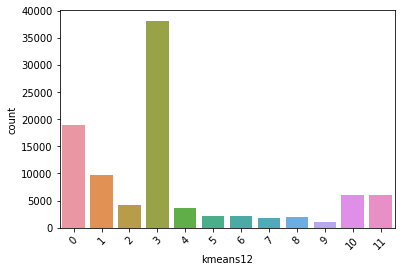

In [181]:
ax = sns.countplot(x= 'kmeans12', data=kmeans_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [209]:
#function to find the most common words within each cluster
def get_most_common_words(df, df_column, num_words):
    common_words = []
    for i in range(0,12):
        common = Counter(" ".join(df.loc[df_column == i]['stemmed']).split()).most_common(num_words)
        for j in common:
            dict_ = {}
            dict_['cluster'] = i
            dict_['word'] = j[0]
            common_words.append(dict_)
            
    return common_words    
            

In [210]:
get_most_common_words(kmeans_df, kmeans_df['kmeans12'], 25)

[{'cluster': 0, 'word': 'state'},
 {'cluster': 0, 'word': 'said'},
 {'cluster': 0, 'word': "'s"},
 {'cluster': 0, 'word': 'new'},
 {'cluster': 0, 'word': 'year'},
 {'cluster': 0, 'word': 'presid'},
 {'cluster': 0, 'word': 'peopl'},
 {'cluster': 0, 'word': 'nation'},
 {'cluster': 0, 'word': '``'},
 {'cluster': 0, 'word': 'one'},
 {'cluster': 0, 'word': 'unit'},
 {'cluster': 0, 'word': 'countri'},
 {'cluster': 0, 'word': 'govern'},
 {'cluster': 0, 'word': 'would'},
 {'cluster': 0, 'word': 'report'},
 {'cluster': 0, 'word': 'two'},
 {'cluster': 0, 'word': 'american'},
 {'cluster': 0, 'word': 'last'},
 {'cluster': 0, 'word': 'u.s.'},
 {'cluster': 0, 'word': 'offici'},
 {'cluster': 0, 'word': 'week'},
 {'cluster': 0, 'word': 'citi'},
 {'cluster': 0, 'word': 'time'},
 {'cluster': 0, 'word': 'polit'},
 {'cluster': 0, 'word': 'day'},
 {'cluster': 1, 'word': 'trump'},
 {'cluster': 1, 'word': 'presid'},
 {'cluster': 1, 'word': 'donald'},
 {'cluster': 1, 'word': 'said'},
 {'cluster': 1, 'word': "

In [47]:
Counter(" ".join(kmeans_df.loc[kmeans_df['kmeans12'] == 9]['stemmed']).split()).most_common(10)

[('polic', 5375),
 ('offic', 2748),
 ('said', 2244),
 ('kill', 1398),
 ('man', 1101),
 ('shoot', 975),
 ('peopl', 967),
 ("'s", 935),
 ('shot', 927),
 ('attack', 915)]

In [3]:
#check clusters manually
#kmeans_df.loc[kmeans_df['kmeans12'] == 9]['stemmed'][:10].values

In [174]:
X_test_2 = ["""He has been training populists in Italy and fomenting revolution in Belgium. He has been down in Texas,
building a wall. But these have all been halting projects, placeholders. The real question is whether Steve Bannon 
will be back by Donald Trump’s side in 2020, after a two-year exile from Trumpworld. That could happen, at least 
according to Trump himself. “I’ll tell you one thing,” Trump said when I asked him about Bannon in February, 
during an Oval Office interview. “I watched Bannon a few times, four or five times over the last six months. 
Nobody says anything better about me right now than Bannon. I don’t know.” Bannon, of course, was the mastermind who 
took over a faltering Trump campaign in August 2016, guiding it to improbable victory. He then served as Trump’s 
chief political strategist in the White House, only to be forced out by Trump’s second chief of staff, John Kelly, 
in a move that a plainly exhausted Bannon seemed to almost welcome after months of battling the president’s 
son-in-law, Jared Kushner, the president’s daughter Ivanka Trump and, well, pretty much everyone else."""]

In [175]:
def text_prep(sample_text):
    tokens = word_tokenize(str(sample_text), language = 'en')
    no_stops = remove_stops(tokens)
    stemmed = stem_list(no_stops)
    stemmed = stemmed.replace('\\n', '')
    return [stemmed]

In [176]:
text_prep(X_test_2)

["'he train populist itali foment revolut belgium He texa build wall but halt project placehold the real question whether steve bannon will back donald trump side 2020 two-year exil trumpworld that could happen least accord trump tell one thing trump said ask bannon februari dure oval offic interview watch bannon time four five time last six month nobodi say anyth better right bannon know. bannon cours mastermind took falter trump campaign august 2016 guid improb victori He serv trump chief polit strategist white hous forc trump second chief staff john kelli in move plainli exhaust bannon seem almost welcom month battl presid son-in-law jare kushner presid daughter ivanka trump well pretti much everyon els"]

<h3>Merge Kmeans12 into original df
    

In [118]:
df_clusters = pd.concat([df, kmeans_df['kmeans12']], axis = 1, sort = False)

In [132]:
#df_clusters.head(100)

In [122]:
#overwrite previous csv with clusters df
df_clusters.to_csv('../Data/df_english_articles.csv')

In [124]:
df_clusters.shape


(95790, 12)

<h3>Re-Cluster Cluster #3

In [187]:
kmeans12_cluster3 = pd.DataFrame(df_clusters['kmeans12'].loc[df_clusters['kmeans12'] == 3])

In [188]:
kmeans12_cluster3['stemmed'] = kmeans_df['stemmed']

In [189]:
kmeans12_cluster3

kmeans12                                            stemmed
0             3  never showtim new seri reviv spoiler ahead epi...
1             3  alphago victori defeat human opportun loss hum...
2             3  weapon war becam weapon web everi year artist ...
4             3  insid test flight facebook first internet dron...
5             3  gadget shop chanc soon plunk cash new smartpho...
6             3  rare sunni day seattl phil spencer seem pleas ...
7             3  termin resurrectedon set arnold could best ter...
8             3  start shot jameson 9:45pm la vega feel like pl...
9             3  crisp afternoon late last year made way manhat...
10            3  reach break point mani parent two half month n...
11            3  airport trigger anxieti subway system caus par...
12            3  appl final announc augment realiti platform de...
13            3  internet ad-track machin true long enough rare...
14            3  wonder woman begin paradisiac island home amaz...
15            3  facial recognit system made huge technolog lea...
16            3  scientist move mous whisker ear paw use electr...
18            3  steven univers emerg one import cartoon televi...
20            3  imagin futur tap app smartphon summon self-dri...
22            3  technolog startup fleet prone failur crop disa...
26            3  trick brain feel pain without medic use electr...
28            3  put monkey diet delay health problem old age n...
29            3  audienc associ word horror scari movi terrifi ...
30            3  thing vine becom internet premier tool make sh...
31            3  person desktop comput use exclus expens machin...
33            3  's brew mac vs. pc war back appl microsoft sha...
34            3  today big tech news might fancy-look surfac st...
35            3  public event like convent strap virtual realit...
37            3  explod phone seem like freak accid chemic prop...
38            3  nathan copeland abl move leg hand sinc broke n...
39            3  motion sick long bane virtual realiti associ s...
...         ...                                                ...
95746         3  anyon ever watch westminst kennel club dog sho...
95748         3  nearli dozen year ago jo blackwell-preston kam...
95749         3  winter olymp fashion larg tale two event open ...
95750         3  runtuna sweden cri hell hell ring across snow-...
95751         3  citi pizza-craz new york pizza war erupt regul...
95752         3  record-set 5,694th home run 2017 season soar r...
95753         3  kennedi space center fla. search cosmic real e...
95755         3  ann jeffrey sophist blond actress singer play ...
95756         3  mother singl parent much youth work day 12 yea...
95760         3  live affluent commun new jersey scientist ph.d...
95761         3  blink light click sound coin perk like free in...
95762         3  bill henfey park three block beach new jersey ...
95763         3  kim velsey lifelong runner suffer hamstr injur...
95764         3  long oddli far-flung collabor colorado museum ...
95765         3  jame alex field jr. ohio charg second-degre mu...
95766         3  basebal great power partnership rang foundat b...
95767         3  star stripe project beaux-art facad new york p...
95769         3  good morn olymp embarrass loyalti test black p...
95772         3  olymp ice danc competit came dress monday nigh...
95773         3  got water saturday lewi pugh terrifi mr. pugh ...
95776         3  atlanta profession athlet hello roger feder tr...
95779         3  renov apart stone hous croatia 2.1 million 1.7...
95780         3  adam wilk met left-hand pitch major leagu two ...
95781         3  follow text statement releas monday beverli yo...
95783         3  rick roja report time grew beaumont beaumont t...
95784         3  london might call triumphal return angel ameri...
95786         3  band popular song night drove old dixi ex-conf...
95787         3  rev billi graham admit later year lea

In [190]:
documents_cluster3 = kmeans12_cluster3['stemmed'].to_list()

In [191]:
cluster_3_vectorized = vectorize_texts(documents_cluster3)

Performing vectorization and TF/IDF transformation on texts...


In [192]:
kmeans10_cluster3= cluster_texts(10, cluster_3_vectorized)

Beginning KMeans Clustering, number of clusters =  10 

Initialization complete
Iteration  0, inertia 73317.229
Iteration  1, inertia 37568.404
Iteration  2, inertia 37503.549
Iteration  3, inertia 37481.140
Iteration  4, inertia 37468.097
Iteration  5, inertia 37459.530
Iteration  6, inertia 37454.379
Iteration  7, inertia 37451.283
Iteration  8, inertia 37449.074
Iteration  9, inertia 37447.200
Iteration 10, inertia 37445.578
Iteration 11, inertia 37444.275
Iteration 12, inertia 37443.478
Iteration 13, inertia 37442.821
Iteration 14, inertia 37442.291
Iteration 15, inertia 37441.787
Iteration 16, inertia 37441.204
Iteration 17, inertia 37440.715
Iteration 18, inertia 37440.219
Iteration 19, inertia 37439.785
Iteration 20, inertia 37439.467
Iteration 21, inertia 37439.173
Iteration 22, inertia 37438.960
Iteration 23, inertia 37438.762
Iteration 24, inertia 37438.615
Iteration 25, inertia 37438.483
Iteration 26, inertia 37438.205
Iteration 27, inertia 37437.744
Iteration 28, inertia 37

In [194]:
kmeans_10_cluster3 = pd.DataFrame(kmeans10_cluster3.labels_)

In [197]:
kmeans_10_cluster3['stemmed'] = kmeans_df['stemmed']

In [202]:
kmeans_10_cluster3[0].value_counts()

4    9472
5    5874
6    4579
9    4031
3    3765
8    3218
7    2508
2    2197
1    1822
0     703
Name: 0, dtype: int64

In [212]:
get_most_common_words(kmeans_10_cluster3, kmeans_10_cluster3[0], 25)

[{'cluster': 0, 'word': 'trump'},
 {'cluster': 0, 'word': '``'},
 {'cluster': 0, 'word': 'one'},
 {'cluster': 0, 'word': 'new'},
 {'cluster': 0, 'word': "'s"},
 {'cluster': 0, 'word': 'year'},
 {'cluster': 0, 'word': 'presid'},
 {'cluster': 0, 'word': 'said'},
 {'cluster': 0, 'word': 'donald'},
 {'cluster': 0, 'word': 'would'},
 {'cluster': 0, 'word': 'state'},
 {'cluster': 0, 'word': 'two'},
 {'cluster': 0, 'word': 'first'},
 {'cluster': 0, 'word': 'time'},
 {'cluster': 0, 'word': 'last'},
 {'cluster': 0, 'word': 'peopl'},
 {'cluster': 0, 'word': 'like'},
 {'cluster': 0, 'word': 'nation'},
 {'cluster': 0, 'word': 'day'},
 {'cluster': 0, 'word': 'say'},
 {'cluster': 0, 'word': 'week'},
 {'cluster': 0, 'word': 'clinton'},
 {'cluster': 0, 'word': 'american'},
 {'cluster': 0, 'word': 'make'},
 {'cluster': 0, 'word': 'republican'},
 {'cluster': 1, 'word': 'trump'},
 {'cluster': 1, 'word': '``'},
 {'cluster': 1, 'word': "'s"},
 {'cluster': 1, 'word': 'said'},
 {'cluster': 1, 'word': 'one'},

After reviewing the top words in each of the clusters, they all seem to be political. This leads me to believe that cluster 3 in fact was properly clustered considering the articles were pulled from 2012-2017, right in the midst of the 2016 election period. Going forward, I will add more non-political articles to the dataset in order to adjust the class imbalance. 